In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۵ — درخت‌های تصمیم و گونه‌ها
## درس ۱۰: قیود یکنواختی و قواعد کسب‌وکار در مدل‌های درختی (مفاهیم)

### در این درس چه چیزهایی یاد می‌گیرید
در پایان این نوت‌بوک باید بتوانید:

- توضیح دهید **قید یکنواختی (Monotonic Constraint)** چیست و چرا در محصولات واقعی (اعتبارسنجی، قیمت‌گذاری، ریسک، تریاژ پزشکی) به‌کار می‌رود.
- **قواعد کسب‌وکار** را به «قید شکل» برای مدل تبدیل کنید (افزایشی/کاهشی/خنثی برای هر ویژگی).
- تفاوت **قید سخت** (در خود الگوریتم enforce می‌شود) و **قید نرم** (به‌صورت regularization یا post-processing) را درک کنید.
- با یک پیاده‌سازی مدرن از مدل‌های درختی/GBDT (مثل `HistGradientBoosting*` در scikit-learn) مدل **بدون قید** و **دارای قید** آموزش دهید.
- با بررسی **Partial Dependence** و اجرای یک **بررسی تجربی یکنواختی**، رعایت قیود را اعتبارسنجی کنید.
- بدانید قیود چه زمانی مفیدند، چه زمانی می‌توانند به عملکرد آسیب بزنند، و چه تست‌ها/حکمرانی‌ای باید پیرامون آن‌ها داشته باشید.

> **نکات مهم این دوره**  
> - فرمول‌ها در سلول‌های Markdown با `$ ... $` (درون‌خطی) و `$$ ... $$` (نمایشی) نوشته می‌شوند.  
> - مسیر دیتاست‌ها **نسبت به همین نوت‌بوک** است و دقیقاً مطابق ساختار ریپازیتوری شماست.

---

### چرا قیود یکنواختی مهم هستند؟ (انگیزه)

در بسیاری از کاربردهای ML جدولی (Tabular)، فقط «دقت بالا» کافی نیست. شما می‌خواهید مدل منطق دامنه‌ای را که ذی‌نفعان آن را غیرقابل‌مذاکره می‌دانند، رعایت کند. یک مثال کلاسیک:

- در ریسک اعتباری: با ثابت بودن سایر عوامل، **درآمد بالاتر نباید ریسک نکول را افزایش دهد** (ریسک نسبت به درآمد باید یکنواختِ کاهشی باشد).
- در قیمت‌گذاری بیمه: **کارکرد بالاتر (mileage)** معمولاً نباید ریسک/هزینه مورد انتظار را کاهش دهد (ریسک نسبت به mileage باید یکنواختِ افزایشی باشد).
- در تریاژ پزشکی: **`Glucose` بالاتر** نباید احتمال دیابت پیش‌بینی‌شده را کم کند (ریسک نسبت به `Glucose` باید یکنواختِ افزایشی باشد).

اگر یک مدل انعطاف‌پذیر این انتظارات را نقض کند، معمولاً با این مشکلات روبه‌رو می‌شوید:
- گفتگوهای دشوار با مالکان کسب‌وکار («چرا وقتی درآمد کم شد، ریسک هم کم شد؟»)،
- دغدغه‌های تطبیق/ممیزی،
- کاهش اعتماد و پذیرش،
- شکست‌های لبه‌ای که دیباگ کردنشان سخت است.

قیود یکنواختی یکی از ساده‌ترین و رایج‌ترین انواع «قید شکل» هستند. این قیود همه مسائل حکمرانی را حل نمی‌کنند، اما اغلب به‌عنوان یک **گاردریل قدرتمند** با هزینه مهندسی نسبتاً پایین عمل می‌کنند.


## ۱) «یکنواختی» دقیقاً یعنی چه؟ (رسمی ولی کاربردی)

### یکنواختی تک‌متغیره
یک تابع $f(x)$ **یکنواختِ غیرکاهشی** است اگر:

$$
x_1 \le x_2 \;\Rightarrow\; f(x_1) \le f(x_2)
$$

و **یکنواختِ غیر افزایشی** است اگر:

$$
x_1 \le x_2 \;\Rightarrow\; f(x_1) \ge f(x_2)
$$

به «غیر-» دقت کنید: برابری مجاز است. در عمل این نکته مهم است چون بسیاری از ویژگی‌ها گسسته‌اند یا نواحی تخت دارند.

### یکنواختی چندمتغیره نسبت به یک ویژگی
در ML معمولاً $x \in \mathbb{R}^d$ و مدل $f(x)$ داریم. یک **قید یکنواختی روی ویژگی $j$** معمولاً یعنی:

- سایر مختصات را ثابت نگه دارید،
- $x_j$ را افزایش دهید،
- پیش‌بینی باید در جهت مجاز (بالا یا پایین) حرکت کند.

به‌صورت رسمی، برای حالت *غیرکاهشی* نسبت به ویژگی $j$:

$$
x_j \le x'_j \;\Rightarrow\; f(x_1,\dots,x_j,\dots,x_d) \le f(x_1,\dots,x'_j,\dots,x_d)
$$

این یک مفهوم **ترتیب جزئی** است. مدل هنوز می‌تواند وقتی چند ویژگی را هم‌زمان تغییر می‌دهید رفتار غیر یکنواخت داشته باشد؛ قید فقط تغییرات روی محور مشخص‌شده را کنترل می‌کند.

### چرا این یک «قاعده کسب‌وکار» است؟
ذی‌نفعان اغلب قواعد را به‌صورت گزاره‌های خلاف‌واقع (counterfactual) بیان می‌کنند:

- «اگر درآمد مشتری زیاد شود (و هیچ چیز دیگری تغییر نکند)، ریسک او نباید بالا برود.»
- «اگر خانه بزرگ‌تر شود و محله و سایر ویژگی‌ها ثابت باشند، قیمت پیش‌بینی‌شده نباید پایین بیاید.»

این دقیقاً همان چیزی است که قیود یکنواختی کُد می‌کنند.

---

## ۲) قیود یکنواختی چگونه با مدل‌های درختی تعامل دارند؟

### درخت تصمیم تابعی پله‌ای/قطعه‌ای است
یک درخت تصمیم استاندارد، فضای ویژگی‌ها را به برگ‌ها تقسیم می‌کند و در هر برگ یک مقدار ثابت خروجی می‌دهد. بدون قید، هیچ چیز جلوی الگوی تقسیم‌بندی‌ای را نمی‌گیرد که روی یک محور رفتاری «زیگزاگی» ایجاد کند.

### Ensembleها می‌توانند «نوسان‌ها» را تقویت کنند
Random Forest و به‌خصوص Boosted Trees (GBDT) تعداد زیادی درخت را ترکیب می‌کنند. این کار قدرت پیش‌بینی را بالا می‌برد، اما می‌تواند شکل‌های پیچیده و غیر شهودی بسازد. یک آرتیفکت کوچک در داده ممکن است یک وارونگی موضعی ایجاد کند که برای کسب‌وکار غیرمنطقی به نظر برسد.

### یادگیری مقید: شکل به‌عنوان بخشی از کلاس فرضیه
اضافه کردن قید یکنواختی، *مجموعه مدل‌های مجاز* را تغییر می‌دهد. عملاً می‌گویید:

> «از بین همه مدل‌های خوب، فقط آن‌هایی را در نظر بگیر که این روابط یکنواختی را رعایت می‌کنند.»

این کار می‌تواند:
- اگر قاعده درست باشد تعمیم را بهتر کند (به‌عنوان inductive bias)،
- کیس‌های لبه‌ای آسیب‌زا را کم کند،
- توضیح‌پذیری را ساده‌تر کند.

اما می‌تواند:
- اگر فرض غلط یا بیش از حد سخت‌گیرانه باشد عملکرد را بدتر کند،
- مسائل داده را پنهان کند (مثلاً شما مدل را مجبور می‌کنید یک سیگنال واقعی را نادیده بگیرد).

پس قیدها «مجانی» نیستند؛ یک تصمیم طراحی‌اند و باید اعتبارسنجی شوند.

---

## ۳) قواعد سخت در برابر قواعد نرم (یک مدل ذهنی مفید)

**قید سخت:** الگوریتم آموزش *هیچ‌وقت* مدلی تولید نمی‌کند که قید را نقض کند (در حد تلورانس‌های عددی).  
مثال: monotonic constraints در بعضی پیاده‌سازی‌های GBDT.

**قید نرم:** نقض قید مجاز است اما جریمه می‌شود (یا بعداً اصلاح می‌شود).  
مثال‌ها:
- اضافه کردن جمله جریمه به تابع خطا برای نقض یکنواختی،
- post-process کردن پیش‌بینی‌ها با isotonic regression (در ۱ بعد) یا smoothing مقید،
- رد/override برخی پیش‌بینی‌ها با یک لایه قواعد.

قید سخت زمانی عالی است که:
- قاعده واقعاً غیرقابل‌مذاکره باشد،
- هزینه دیدن یک نقض بالا باشد (تطبیق، ایمنی)،
- ممیزی قطعی و تکرارپذیر بخواهید.

قید نرم زمانی مفید است که:
- قاعده «اغلب درست» است اما استثناهای واقعی دارد،
- می‌خواهید بین وفاداری به قاعده و دقت، trade-off داشته باشید.

در این نوت‌بوک تمرکز اصلی روی *قیود یکنواختی سخت* در یادگیرنده‌های درختی/GBDT خواهد بود.


## ۴) نمایش/کُد کردن قیود یکنواختی در عمل

بیشتر کتابخانه‌ها قیود یکنواختی را با یک بردار از علامت‌ها (signs) که با **ترتیب ویژگی‌های ورودی** هم‌راستا است نمایش می‌دهند:

- `+1`: با افزایش ویژگی، پیش‌بینی باید **غیرکاهشی** باشد.
- `-1`: با افزایش ویژگی، پیش‌بینی باید **غیرافزایشی** باشد.
- `0`: بدون قید (مدل می‌تواند هر شکلی را یاد بگیرد).

برای مثال اگر بردار ویژگی شما این باشد:

`[income, age, debt_to_income, num_late_payments]`

یک مجموعه قاعده رایج برای ریسک اعتباری می‌تواند چنین باشد:

- `income`: `-1` (درآمد بالاتر نباید ریسک را افزایش دهد)،
- `age`: `0` (نامطمئن / ممکن است به دلیل غیرخطی بودن غیر یکنواخت باشد)،
- `debt_to_income`: `+1`,
- `num_late_payments`: `+1`.

پس بردار قید یکنواختی می‌شود:

`[-1, 0, +1, +1]`

### پیش‌پردازش، نگاشت را پیچیده می‌کند
پایپ‌لاین‌های واقعی معمولاً تبدیل‌های ویژگی انجام می‌دهند:

- One-hot encoding از یک ویژگی دسته‌ای چند ستون می‌سازد،
- استانداردسازی مقیاس‌ها را تغییر می‌دهد،
- ویژگی‌های تعاملی (interaction) محورهای جدیدی می‌سازند.

وقتی قید یکنواختی می‌گذارید باید مطمئن شوید بردار قید با **فضای ویژگیِ نهاییِ تبدیل‌شده** دقیقاً هم‌طول و هم‌راستا است.

در این نوت‌بوک:
1) یک `ColumnTransformer` را fit می‌کنیم،  
2) نام ویژگی‌های خروجی را (در صورت امکان با `get_feature_names_out()`) می‌گیریم،  
3) یک بردار قید هم‌اندازه می‌سازیم.

---

## ۵) قیود یکنواختی چه چیزهایی را حل نمی‌کنند؟

وسوسه‌انگیز است قیود یکنواختی را یک ابزار جادویی برای fairness یا governance بدانیم؛ اما چنین نیست. این قیود فقط نوع محدودی از «معقول بودن» را enforce می‌کنند:

- **درستی علّی** را تضمین نمی‌کنند (همچنان مسئله correlation vs causation داریم).
- از **leakage** جلوگیری نمی‌کنند (یک ویژگی نشتی‌دار می‌تواند همچنان یکنواخت باشد).
- **کالیبراسیون** را تضمین نمی‌کنند (یک امتیاز یکنواخت می‌تواند بدکالیبره باشد).
- **پایداری زمانی** را تضمین نمی‌کنند (drift می‌تواند فرضیات شما را بشکند).
- محدودیت «بدون تعامل» را کُد نمی‌کنند (مگر این‌که کتابخانه interaction constraints هم پشتیبانی کند).

به قیود یکنواختی به چشم یک **گاردریل شکل** نگاه کنید، نه راه‌حل کامل حکمرانی.

---

## ۶) شروع کنیم: بارگذاری داده و ساخت دموها

ما از سه دیتاست موجود در ریپازیتوری شما استفاده می‌کنیم (مسیرها نسبی هستند):

- `../../../Datasets/Regression/house-prices.csv` (رگرسیون)
- `../../../Datasets/Classification/diabetes.csv` (طبقه‌بندی دودویی)
- `../../../Datasets/Classification/Wine_Quality.csv` (هدف شبیه رگرسیون)

نشان می‌دهیم:
- یک مثال رگرسیون که قیود یکنواختی با شهود کسب‌وکار هم‌خوان است،
- یک مثال طبقه‌بندی با شهود بالینی،
- و یک مثال که در آن قیدها «محتمل» به نظر می‌رسند اما ممکن است عملکرد را بدتر کنند.

سلول‌های بعدی را به ترتیب اجرا کنید.


## ۷) تفسیر نتایج: دقت در برابر وفاداری به قاعده

وقتی مدل‌های دارای قید و بدون قید را مقایسه می‌کنید، فقط روی یک معیار تمرکز نکنید. حداقل به سه زاویه نگاه کنید:

### (A) عملکرد پیش‌بینی
- رگرسیون: RMSE/MAE و شاید $R^2$
- طبقه‌بندی: ROC AUC، دقت، و PR AUC (اگر داده نامتوازن است)

### (B) انطباق با شکل (آیا مدل قاعده را رعایت می‌کند؟)
برای یک ویژگی مشخص:
- نمودارهای Partial Dependence را بررسی کنید (نمای کلی/میانگین‌گیری شده)،
- تست‌های خلاف‌واقعی انجام دهید (فقط همان ویژگی را تغییر دهید)،
- به دنبال نقض‌های موضعی بگردید.

در این نوت‌بوک یک **نرخ نقض تجربی** می‌بینید: کسری از زوج‌های نمونه‌برداری‌شده که در آن افزایش یک ویژگی مقید باعث شده پیش‌بینی در جهت اشتباه حرکت کند.

### (C) ریسک محصول / حکمرانی
حتی اگر عملکرد کمی بدتر شود، ممکن است قیدها همچنان ارزشمند باشند، وقتی که:
- قاعده طبق سیاست الزامی است،
- نقض قاعده باعث آسیب به کاربر یا ریسک حقوقی می‌شود،
- توضیح‌پذیری یک الزام اصلی است.

اما اگر قیدها عملکرد را به‌شدت کم کنند، این یک سیگنال است برای:
- بازبینی فرض،
- بررسی معنای ویژگی (آیا proxy چیزی دیگر است؟),
- در نظر گرفتن قید نرم، یا اعمال قید فقط در برخی رژیم‌ها (مثلاً بعد از یک آستانه).

---

## ۸) یک نکته عملی: یکنواختی و ویژگی‌های دسته‌ای

قیود یکنواختی ذاتاً روی ویژگی‌های **دارای ترتیب** تعریف می‌شوند (عددی یا ordinal). برای یک دسته‌بندی صرفاً نامی مثل `Neighborhood`، «افزایش neighborhood» معنا ندارد.

وقتی یک ویژگی دسته‌ای را one-hot می‌کنید، ستون‌های دودویی می‌سازید:
- `Neighborhood_East`
- `Neighborhood_West`
- ...

گذاشتن قید یکنواختی روی این ستون‌های one-hot معمولاً **معنادار نیست**. در این نوت‌بوک به‌صورت پیش‌فرض برای آن‌ها مقدار `0` می‌گذاریم.

اگر یک دسته‌بندی **ordinal** دارید (مثل `risk_band` با سطوح low/medium/high)، آن را به صورت عدد مرتب‌شده یا ordinal encoding کُد کنید؛ در آن صورت قیود یکنواختی می‌تواند معنا داشته باشد.

---

## ۹) خلاصه کاری که کد انجام می‌دهد

کدی که اجرا می‌کنید:

1) دیتاست‌ها را از مسیرهای ریپازیتوری شما بارگذاری می‌کند.  
2) یک `HistGradientBoostingRegressor` بدون قید روی قیمت خانه آموزش می‌دهد.  
3) نسخه مقید را با قید یکنواختی روی `SqFt`، `Bedrooms`، `Bathrooms`، `Offers` آموزش می‌دهد.  
4) Partial Dependence مربوط به `SqFt` را رسم می‌کند.  
5) یک بررسی یکنواختی انجام می‌دهد و نرخ نقض را برآورد می‌کند.  
6) همین ایده را برای طبقه‌بندی دیابت با قید روی `Glucose`، `BMI`، `Age` تکرار می‌کند.  
7) با دیتاست Wine Quality نشان می‌دهد که قیدها می‌توانند «محتمل» باشند اما باز هم به عملکرد آسیب بزنند.

> اگر نسخه scikit-learn شما `monotonic_cst` را پشتیبانی نکند، نوت‌بوک باز هم اجرا می‌شود و پیام مناسب چاپ می‌کند.  
> در صورت نصب بودن، می‌توانید سلول دمو مربوط به XGBoost را هم امتحان کنید.


In [2]:
# Core libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
import inspect
import textwrap
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [3]:
# Helper: load CSV with a robust path check (relative to this notebook)
def load_csv(rel_path: str) -> pd.DataFrame:
    p = Path(rel_path)
    if not p.exists():
        raise FileNotFoundError(f"Could not find: {p.resolve()}")
    return pd.read_csv(p)

# Pick 3 datasets for this lesson (random-ish but deterministic for reproducibility)
DATASETS = {
    "house_prices": "../../../Datasets/Regression/house-prices.csv",
    "diabetes": "../../../Datasets/Classification/diabetes.csv",
    "wine_quality": "../../../Datasets/Classification/Wine_Quality.csv",
}

for k, v in DATASETS.items():
    print(k, "->", v)

house_prices -> ../../../Datasets/Regression/house-prices.csv
diabetes -> ../../../Datasets/Classification/diabetes.csv
wine_quality -> ../../../Datasets/Classification/Wine_Quality.csv


In [4]:
# Quick peek: first rows (sanity check that paths and headers match)
house = load_csv(DATASETS["house_prices"])
diab = load_csv(DATASETS["diabetes"])
wine = load_csv(DATASETS["wine_quality"])

display(house.head())
display(diab.head())
display(wine.head())

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
# Scikit-learn setup (we'll gracefully adapt if your installed version differs)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Choose OneHotEncoder argument depending on sklearn version
ohe_sig = inspect.signature(OneHotEncoder).parameters
if "sparse_output" in ohe_sig:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

print("OneHotEncoder configured:", ohe)

OneHotEncoder configured: OneHotEncoder(handle_unknown='ignore', sparse_output=False)


In [6]:
# Determine whether HistGradientBoosting supports monotonic constraints in this environment
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

hgb_reg_sig = inspect.signature(HistGradientBoostingRegressor).parameters
hgb_clf_sig = inspect.signature(HistGradientBoostingClassifier).parameters

supports_monotonic_reg = "monotonic_cst" in hgb_reg_sig
supports_monotonic_clf = "monotonic_cst" in hgb_clf_sig

print("HistGradientBoostingRegressor supports monotonic_cst:", supports_monotonic_reg)
print("HistGradientBoostingClassifier supports monotonic_cst:", supports_monotonic_clf)

HistGradientBoostingRegressor supports monotonic_cst: True
HistGradientBoostingClassifier supports monotonic_cst: True


In [7]:
# Utility: build monotonic constraint vectors that align with the *transformed* feature space
def build_monotonic_cst(feature_names, rules):
    '''
    feature_names: list of transformed feature names (after preprocessing)
    rules: dict of base feature names to constraint sign {+1, 0, -1}
           For one-hot features, we map them to 0 by default, unless you explicitly add a rule.
    '''
    cst = []
    for fn in feature_names:
        base = fn.split("__")[-1]  # ColumnTransformer adds prefixes like "num__SqFt"
        # One-hot feature names often look like "cat__Neighborhood_East"
        base_key = base.split("_")[0] if "_" in base and base.split("_")[0] in rules else base
        cst.append(int(rules.get(base_key, 0)))
    return np.array(cst, dtype=int)

def monotonicity_check(model, X: np.ndarray, feature_index: int, direction: int, n_pairs: int = 2000, seed: int = 7):
    '''
    Empirical monotonicity check by sampling pairs (x, x') that differ in one feature.
    direction: +1 means f should be non-decreasing when feature increases
               -1 means f should be non-increasing when feature increases
    Returns a violation rate in [0, 1].
    '''
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.integers(0, n, size=n_pairs)
    X1 = X[idx].copy()
    X2 = X1.copy()

    # perturb the chosen feature upward by a random positive delta
    deltas = rng.uniform(0.05, 0.5, size=n_pairs)
    X2[:, feature_index] = X2[:, feature_index] + deltas

    y1 = model.predict(X1)
    y2 = model.predict(X2)

    if direction == +1:
        violations = (y2 < y1).mean()
    elif direction == -1:
        violations = (y2 > y1).mean()
    else:
        violations = np.nan
    return float(violations)

print("Utilities loaded.")

Utilities loaded.


In [8]:
# 1) Regression demo: House Prices
df = house.copy()

target = "Price"
X = df.drop(columns=[target])
y = df[target]

num_features = ["SqFt", "Bedrooms", "Bathrooms", "Offers"]
cat_features = ["Brick", "Neighborhood"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", ohe, cat_features),
    ],
    remainder="drop"
)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit preprocessing only to get feature names for monotonic vector construction
preprocess.fit(X_train)
try:
    feat_names = preprocess.get_feature_names_out()
except Exception:
    # Older sklearn may not have get_feature_names_out for ColumnTransformer in the same way
    feat_names = np.array([f"f{i}" for i in range(preprocess.transform(X_train).shape[1])])

print("Transformed feature count:", len(feat_names))
print("Sample feature names:", feat_names[:10])

Transformed feature count: 9
Sample feature names: ['num__SqFt' 'num__Bedrooms' 'num__Bathrooms' 'num__Offers'
 'cat__Brick_No' 'cat__Brick_Yes' 'cat__Neighborhood_East'
 'cat__Neighborhood_North' 'cat__Neighborhood_West']


In [9]:
# Baseline model (unconstrained)
baseline_reg = HistGradientBoostingRegressor(
    random_state=42,
    max_depth=6,
    learning_rate=0.08,
    max_iter=400
)

baseline_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", baseline_reg)
])

baseline_pipe.fit(X_train, y_train)
pred = baseline_pipe.predict(X_test)

rmse = mean_squared_error(y_test, pred, squared=False)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"Baseline RMSE: {rmse:,.2f}")
print(f"Baseline MAE : {mae:,.2f}")
print(f"Baseline R^2 : {r2:.3f}")

Baseline RMSE: 12,737.17
Baseline MAE : 9,452.55
Baseline R^2 : 0.735


In [10]:
# Constrained model (monotonic constraints)
# Business assumption for illustration:
# - Price should be non-decreasing with SqFt, Bedrooms, Bathrooms
# - Offers is ambiguous (can be proxy of desirability/competition). We'll set it to +1 as a hypothetical rule.
# - One-hot categories and Brick/Neighborhood are set to 0 in this simple example.

rules = {"SqFt": +1, "Bedrooms": +1, "Bathrooms": +1, "Offers": +1}

if supports_monotonic_reg:
    cst = build_monotonic_cst(list(feat_names), rules)
    print("Constraint vector length:", len(cst), "  unique:", np.unique(cst))

    constrained_reg = HistGradientBoostingRegressor(
        random_state=42,
        max_depth=6,
        learning_rate=0.08,
        max_iter=400,
        monotonic_cst=cst
    )

    constrained_pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", constrained_reg)
    ])

    constrained_pipe.fit(X_train, y_train)
    pred_c = constrained_pipe.predict(X_test)

    rmse_c = mean_squared_error(y_test, pred_c, squared=False)
    mae_c = mean_absolute_error(y_test, pred_c)
    r2_c = r2_score(y_test, pred_c)

    print(f"Constrained RMSE: {rmse_c:,.2f}")
    print(f"Constrained MAE : {mae_c:,.2f}")
    print(f"Constrained R^2 : {r2_c:.3f}")
else:
    print("Your sklearn build does not expose monotonic_cst for HistGradientBoostingRegressor.")
    print("You can still study the concepts here, or use XGBoost/LightGBM if installed.")

Constraint vector length: 9   unique: [0 1]
Constrained RMSE: 11,424.41
Constrained MAE : 8,434.12
Constrained R^2 : 0.787


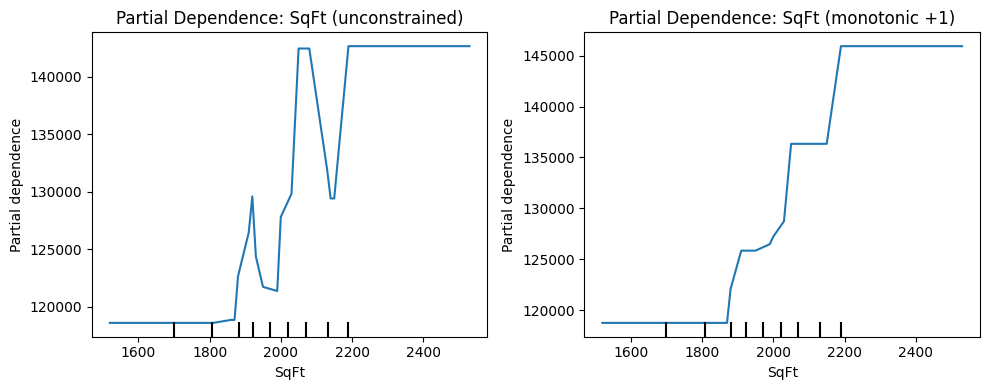

In [11]:
# Partial dependence for SqFt: unconstrained vs constrained (if available)
from sklearn.inspection import PartialDependenceDisplay

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
PartialDependenceDisplay.from_estimator(
    baseline_pipe, X_test, features=["SqFt"], ax=ax1, kind="average"
)
ax1.set_title("Partial Dependence: SqFt (unconstrained)")

ax2 = fig.add_subplot(1, 2, 2)
if supports_monotonic_reg:
    PartialDependenceDisplay.from_estimator(
        constrained_pipe, X_test, features=["SqFt"], ax=ax2, kind="average"
    )
    ax2.set_title("Partial Dependence: SqFt (monotonic +1)")
else:
    ax2.text(0.5, 0.5, "Constrained model not available in this environment", ha="center", va="center")
    ax2.set_title("Partial Dependence: SqFt (constrained)")

plt.tight_layout()
plt.show()

In [12]:
# Empirical monotonicity check in transformed space (only meaningful for constrained model)
# We'll check the first numeric feature in the transformed matrix, which should correspond to SqFt under our transformer order.
Xtr_test = preprocess.transform(X_test)

# In our ColumnTransformer, numeric passthrough comes first in the same order as num_features
sqft_index = 0  # "num__SqFt" typically maps to first numeric column

# Check baseline violations (expected: could violate monotonicity)
base_model = baseline_pipe.named_steps["model"]
# baseline_pipe predicts on raw X; for the checker we want the underlying model on transformed arrays
# We'll fit a model directly on transformed arrays for a clean check.
baseline_direct = HistGradientBoostingRegressor(random_state=42, max_depth=6, learning_rate=0.08, max_iter=400)
baseline_direct.fit(preprocess.transform(X_train), y_train)
viol_base = monotonicity_check(baseline_direct, Xtr_test, sqft_index, direction=+1, n_pairs=3000)
print("Baseline estimated violation rate for SqFt (+1):", viol_base)

if supports_monotonic_reg:
    constrained_direct = HistGradientBoostingRegressor(
        random_state=42, max_depth=6, learning_rate=0.08, max_iter=400, monotonic_cst=cst
    )
    constrained_direct.fit(preprocess.transform(X_train), y_train)
    viol_c = monotonicity_check(constrained_direct, Xtr_test, sqft_index, direction=+1, n_pairs=3000)
    print("Constrained estimated violation rate for SqFt (+1):", viol_c)

Baseline estimated violation rate for SqFt (+1): 0.0
Constrained estimated violation rate for SqFt (+1): 0.0


In [13]:
# 2) Classification demo: Diabetes (binary)
df = diab.copy()

# Map labels to 0/1 without changing original text labels
cls = df["classification"].astype(str).str.strip().str.lower()
y = (cls == "diabetic").astype(int)
X = df.drop(columns=["classification"])

num_features = list(X.columns)
preprocess_d = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

preprocess_d.fit(X_train)
try:
    feat_names_d = preprocess_d.get_feature_names_out()
except Exception:
    feat_names_d = np.array(num_features)

print("Features:", list(feat_names_d))

Features: ['num__Pregnancies', 'num__Glucose', 'num__BloodPressure', 'num__SkinThickness', 'num__Insulin', 'num__BMI', 'num__DiabetesPedigreeFunction', 'num__Age']


In [14]:
# Baseline classifier
baseline_clf = HistGradientBoostingClassifier(
    random_state=42,
    max_depth=4,
    learning_rate=0.06,
    max_iter=400
)

baseline_pipe_d = Pipeline(steps=[
    ("prep", preprocess_d),
    ("model", baseline_clf)
])
baseline_pipe_d.fit(X_train, y_train)

proba = baseline_pipe_d.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
if len(np.unique(y_test)) < 2:
    auc = np.nan
    print("ROC AUC skipped: y_test has one class.")
else:
    auc = roc_auc_score(y_test, proba)

print(f"Baseline Accuracy: {acc:.3f}")
print(f"Baseline ROC AUC : {auc:.3f}")

Baseline Accuracy: 0.719
Baseline ROC AUC : 0.795


In [15]:
# Constrained classifier
# Example business rule: risk should be non-decreasing with Glucose, BMI, Age (common clinical intuition).
# We'll keep all other features unconstrained (0) to avoid over-committing.
rules_d = {"Glucose": +1, "BMI": +1, "Age": +1}

if supports_monotonic_clf:
    cst_d = build_monotonic_cst(list(feat_names_d), rules_d)
    print("Constraint vector unique:", np.unique(cst_d), "length:", len(cst_d))

    constrained_clf = HistGradientBoostingClassifier(
        random_state=42,
        max_depth=4,
        learning_rate=0.06,
        max_iter=400,
        monotonic_cst=cst_d
    )
    constrained_pipe_d = Pipeline(steps=[
        ("prep", preprocess_d),
        ("model", constrained_clf)
    ])
    constrained_pipe_d.fit(X_train, y_train)

    proba_c = constrained_pipe_d.predict_proba(X_test)[:, 1]
    pred_c = (proba_c >= 0.5).astype(int)

    acc_c = accuracy_score(y_test, pred_c)
    if len(np.unique(y_test)) < 2:
        auc_c = np.nan
        print("ROC AUC skipped: y_test has one class.")
    else:
        auc_c = roc_auc_score(y_test, proba_c)

    print(f"Constrained Accuracy: {acc_c:.3f}")
    print(f"Constrained ROC AUC : {auc_c:.3f}")
else:
    print("Your sklearn build does not expose monotonic_cst for HistGradientBoostingClassifier.")

Constraint vector unique: [0 1] length: 8
Constrained Accuracy: 0.740
Constrained ROC AUC : 0.783


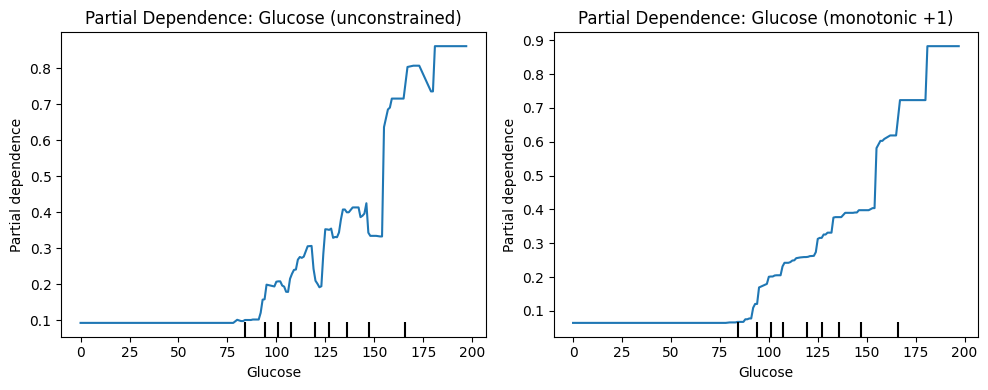

In [16]:
# Plot partial dependence for Glucose (classifier): unconstrained vs constrained (if available)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
PartialDependenceDisplay.from_estimator(
    baseline_pipe_d, X_test, features=["Glucose"], ax=ax1, kind="average"
)
ax1.set_title("Partial Dependence: Glucose (unconstrained)")

ax2 = fig.add_subplot(1, 2, 2)
if supports_monotonic_clf:
    PartialDependenceDisplay.from_estimator(
        constrained_pipe_d, X_test, features=["Glucose"], ax=ax2, kind="average"
    )
    ax2.set_title("Partial Dependence: Glucose (monotonic +1)")
else:
    ax2.text(0.5, 0.5, "Constrained model not available in this environment", ha="center", va="center")
    ax2.set_title("Partial Dependence: Glucose (constrained)")

plt.tight_layout()
plt.show()

In [17]:
# 3) Wine Quality: demonstrate "constraints are assumptions" (can help or hurt)
df = wine.copy()

# We'll treat 'quality' as a regression target for a classical setup
target = "quality"
X = df.drop(columns=[target])
y = df[target]

num_features = list(X.columns)
preprocess_w = ColumnTransformer(
    transformers=[("num", "passthrough", num_features)],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

preprocess_w.fit(X_train)
try:
    feat_names_w = preprocess_w.get_feature_names_out()
except Exception:
    feat_names_w = np.array(num_features)

baseline_w = HistGradientBoostingRegressor(random_state=42, max_depth=4, learning_rate=0.06, max_iter=500)
baseline_pipe_w = Pipeline([("prep", preprocess_w), ("model", baseline_w)])
baseline_pipe_w.fit(X_train, y_train)
pred = baseline_pipe_w.predict(X_test)

rmse = mean_squared_error(y_test, pred, squared=False)
print(f"Baseline RMSE (wine): {rmse:.4f}")

Baseline RMSE (wine): 0.6454


In [18]:
# Apply a plausible-but-not-guaranteed constraint set:
# - alcohol: +1 (often higher alcohol correlates with higher quality in many datasets)
# - volatile acidity: -1 (often higher volatile acidity correlates with lower quality)
# - chlorides: -1 (saltiness/defects)
# Everything else 0 for simplicity.

rules_w = {"alcohol": +1, "volatile acidity": -1, "chlorides": -1}

if supports_monotonic_reg:
    cst_w = build_monotonic_cst(list(feat_names_w), rules_w)

    constrained_w = HistGradientBoostingRegressor(
        random_state=42, max_depth=4, learning_rate=0.06, max_iter=500, monotonic_cst=cst_w
    )
    constrained_pipe_w = Pipeline([("prep", preprocess_w), ("model", constrained_w)])
    constrained_pipe_w.fit(X_train, y_train)
    pred_c = constrained_pipe_w.predict(X_test)

    rmse_c = mean_squared_error(y_test, pred_c, squared=False)
    print(f"Constrained RMSE (wine): {rmse_c:.4f}")

    print("Note: If RMSE worsens, it may mean the monotonic assumptions are too rigid or partially wrong.")
else:
    print("Monotonic constraints not available for regression in this environment.")

Constrained RMSE (wine): 0.6511
Note: If RMSE worsens, it may mean the monotonic assumptions are too rigid or partially wrong.


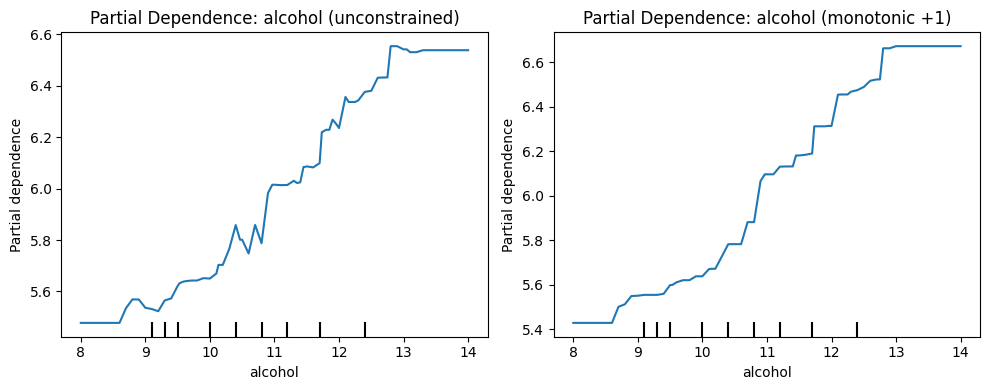

In [19]:
# Optional: quick "shape sanity" plots for alcohol
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
PartialDependenceDisplay.from_estimator(baseline_pipe_w, X_test, features=["alcohol"], ax=ax1, kind="average")
ax1.set_title("Partial Dependence: alcohol (unconstrained)")

ax2 = fig.add_subplot(1, 2, 2)
if supports_monotonic_reg:
    PartialDependenceDisplay.from_estimator(constrained_pipe_w, X_test, features=["alcohol"], ax=ax2, kind="average")
    ax2.set_title("Partial Dependence: alcohol (monotonic +1)")
else:
    ax2.text(0.5, 0.5, "Constrained model not available in this environment", ha="center", va="center")
    ax2.set_title("Partial Dependence: alcohol (constrained)")

plt.tight_layout()
plt.show()

In [20]:
# Optional: If you have XGBoost/LightGBM installed, you can explore monotonic constraints there too.
# This cell is safe to run even if those packages are missing.

def try_xgboost_monotonic_demo():
    try:
        import xgboost as xgb
    except Exception as e:
        print("xgboost not installed:", e)
        return

    # Simple demo: diabetes dataset with constraints
    df = diab.copy()
    cls = df["classification"].astype(str).str.strip().str.lower()
    y = (cls == "diabetic").astype(int).values
    X = df.drop(columns=["classification"]).values

    # Monotone constraints: +1 for Glucose, BMI, Age, 0 for others (order matches column order)
    cols = list(df.drop(columns=["classification"]).columns)
    cst = []
    for c in cols:
        if c in ["Glucose", "BMI", "Age"]:
            cst.append(1)
        else:
            cst.append(0)

    dtrain = xgb.DMatrix(X, label=y, feature_names=cols)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 4,
        "eta": 0.05,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "monotone_constraints": "(" + ",".join(map(str, cst)) + ")"
    }
    model = xgb.train(params, dtrain, num_boost_round=200)
    proba = model.predict(dtrain)
    if len(np.unique(y)) < 2:
        print("XGBoost demo AUC skipped: y has one class.")
    else:
        print("XGBoost demo AUC (train):", roc_auc_score(y, proba))

try_xgboost_monotonic_demo()

XGBoost demo AUC (train): 0.960186567164179


## ۱۰) بررسی عمیق مفهومی: مدل‌های درختی مقید چگونه یکنواختی را enforce می‌کنند؟

کتابخانه‌های مختلف قیود را به شکل‌های متفاوتی پیاده‌سازی می‌کنند، اما ایده اصلی یکی است: یادگیرنده باید تضمین کند که با حرکت روی یک محور مقید، پیش‌بینی نمی‌تواند جهتش را برعکس دیکھد.

### شهود برای GBDT (در سطح بسیار کلی)
GBDT یک مدل جمع‌پذیر می‌سازد:

$$
f(x) = \sum_{t=1}^{T} \eta \, h_t(x)
$$

که در آن هر $h_t$ یک درخت و $\eta$ نرخ یادگیری است.

اگر بخواهیم $f$ نسبت به ویژگی $j$ یکنواخت باشد، باید مجموع درخت‌ها این خاصیت را حفظ کند. یک راه ساده این است که هر درخت را جداگانه مقید کنیم، اما این کار معمولاً خیلی سخت‌گیرانه می‌شود. پیاده‌سازی‌های مدرن با محدود کردن موارد زیر یکنواختی را نگه می‌دارند:
- این‌که چه splitهایی مجاز هستند،
- و این‌که مقادیر برگ‌ها چه محدوده‌ای می‌توانند داشته باشند،
تا تابع کلی یکنواخت بماند.

### یکنواختی «محلی» در برابر «سراسری»
یک یادگیرنده مقید معمولاً چیزی نزدیک به یکنواختی **سراسری** را نسبت به نمایش ویژگیِ تبدیل‌شده تضمین می‌کند. با این حال باید به موارد زیر هم توجه کنید:

- تلورانس‌های عددی،
- آرتیفکت‌های پیش‌پردازش (مثل binning یا مسیر‌دهی مقادیر گمشده),
- تفاوت یکنواختی در ویژگی خام نسبت به ویژگی تبدیل‌شده (log، z-score و ...).

### تفسیر عملی
وقتی برای `SqFt` مقدار `monotonic_cst=+1` می‌گذارید یعنی:

> برای هر دو خانه که در تمام ویژگی‌های کُد شده یکسان‌اند، اگر یکی `SqFt` بیشتری داشته باشد، قیمت پیش‌بینی‌شده‌اش نباید کمتر باشد.

این یک گزاره قوی است. اگر داده شما به‌صورت سیستماتیک آن را نقض کند (مثلاً خانه‌های بزرگ‌تر در منطقه‌ای با افت ارزش باشند)، قید با داده «می‌جنگد» و ممکن است دقت کاهش یابد.

### قیدها به‌عنوان کنترل ریسک
در محیط‌های مقرراتی یا حساس به ایمنی، قیدها نقش **کنترل ریسک** دارند:
- احتمال خروجی‌های «غیرمعقول» را کم می‌کنند،
- قابل مستندسازی و تست هستند،
- معمولاً ممیزی‌شان ساده‌تر از توضیحات پسینی است که برای هر نمونه متفاوت است.

اما کیفیت آن‌ها کاملاً به فرض‌هایی که کُد می‌کنید وابسته است. یک فرایند منظم، قیدها را مثل کد رفتار می‌دهد: نسخه‌بندی، تست، و بازبینی.

---

## ۱۱) قواعد کسب‌وکار فراتر از یکنواختی (یک طبقه‌بندی سریع)

یکنواختی رایج است، اما قواعد واقعی اغلب شامل محدودیت‌های دیگری هم هستند:

1) **قیود بازه‌ای**: خروجی باید در بازه $[a, b]$ باشد (یا ویژگی‌ها clip شوند).  
2) **interaction constraints**: ویژگی A فقط در تعامل با ویژگی B مجاز است.  
3) **قیود ترتیب/بانده‌بندی**: band کردن امتیاز، آستانه‌های tier، یا یکنواختی بین bucketها.  
4) **قیود fairness گروهی**: معیارهای برابری (که صرفاً با یکنواختی حل نمی‌شوند).  
5) **قواعد رد/امتناع**: اگر کیفیت داده پایین است، مدل abstain کند یا به بررسی دستی ارجاع دهد.  
6) **Rule overlay**: یک لایه قطعی که در موارد نادر خروجی مدل را override می‌کند.

در عمل، یک سیستم تولیدی واقع‌بینانه اغلب یکی از این‌هاست:
- مدل آماری + لایه قواعد،
- یا مدل مقید + پایش (monitoring) و override.

انتخاب درست به هزینه خطاها و محیط مقرراتی بستگی دارد.

---

## ۱۲) حالا سلول‌های کد را اجرا کنید

سلول‌های کد بعدی سه دموی گفته‌شده را پیاده‌سازی می‌کنند.

هنگام اجرا، برای خودتان یادداشت کنید:
- چه قیدهایی اعمال کردید،
- در یک کاربرد واقعی کدام قیدها را واقعاً قابل اعتماد می‌دانید،
- و برای توجیه آن‌ها چه شواهدی (دانش دامنه + داده) لازم دارید.


## ۱۳) چک‌لیست عملی: چگونه قیود یکنواختی را ایمن اعمال کنیم؟

قبل از این‌که یک مدل مقید را وارد محصول کنید، یک چک‌لیست شبیه این را مرور کنید:

### A) تعریف قاعده
- آیا قاعده **به‌صورت سراسری** درست است یا فقط در یک سگمنت (مثلاً داخل یک tier محصول)؟
- آیا ویژگی «تمیز» است یا یک proxy است که ممکن است معنی‌اش وارونه شود؟
- آیا به یکنواختی روی یک ویژگی تبدیل‌شده نیاز دارید (مثلاً `log(income)` به جای `income`)؟

### B) اعتبارسنجی داده
- رابطه خام را رسم کنید (scatter، میانگین‌های bin شده) تا ببینید یکنواختی چقدر محتمل است.
- مراقب Simpson’s paradox باشید (ممکن است رابطه کلی یکنواخت به نظر برسد ولی سگمنت‌ها نه).
- مطمئن شوید مقادیر گمشده و outlierها به‌طور سازگار مدیریت می‌شوند.

### C) اعتبارسنجی مدل
- عملکرد مدل مقید و بدون قید را روی چند fold و اگر ممکن است روی زمان‌های مختلف مقایسه کنید.
- هم Partial Dependence و هم counterfactualهای محلی را بررسی کنید.
- نرخ نقض یکنواختی را اندازه‌گیری کنید (مثل کاری که در این نوت‌بوک انجام می‌دهیم).

### D) حکمرانی و پایش
- قیدها را مستند کنید و علت وجودشان را بنویسید (ارجاع سیاست، تأیید دامنه‌ای).
- قیدها را نسخه‌بندی کنید و تغییرات را مثل کد بازبینی کنید.
- drift را پایش کنید: اگر توزیع ویژگی‌ها عوض شود، فرض یکنواختی اولیه ممکن است بشکند.
- مسیرهای جایگزین (fallback) در نظر بگیرید اگر مدل مقید بد عمل کرد.

قیدها فقط یک ترفند مدل‌سازی نیستند؛ بخشی از «قرارداد» بین مدل و کاربرانش هستند.

---

## ۱۴) تمرین‌ها (بعد از اجرای دموها انجام دهید)

این تمرین‌ها برای ساختن «شهود قید» طراحی شده‌اند:

1) **حساسیت به قید**:  
   در دمو قیمت خانه، قید `Offers` را از `+1` به `0` تغییر دهید.  
   دوباره fit کنید و RMSE و شکل Partial Dependence مربوط به `Offers` را مقایسه کنید.

2) **تست بیش‌ازحد مقید کردن**:  
   روی یک ویژگی که احتمالاً یکنواخت نیست قید بگذارید (مثلاً `Bedrooms` ممکن است بازده نزولی یا اثر پله‌ای داشته باشد).  
   ببینید آیا عملکرد افت می‌کند و آیا Partial Dependence به شکل غیرطبیعی «صاف» می‌شود یا نه.

3) **ممیزی یکنواختی**:  
   تابع `monotonicity_check(...)` را طوری تغییر دهید که چند ویژگی را بررسی کند و یک جدول کوچک بدهد: نام ویژگی → نرخ نقض.

4) **داده مصنوعی با حقیقت معلوم**:  
   یک دیتاست مصنوعی بسازید که در آن تابع واقعی نسبت به یک ویژگی یکنواخت و نسبت به دیگری غیر یکنواخت باشد.  
   مدل‌های مقید/بدون قید را آموزش دهید و رفتارشان را مقایسه کنید.

5) **ترجمه قاعده کسب‌وکار به قید**:  
   ۵ قاعده کسب‌وکار از دامنه دلخواهتان (اعتبار، قیمت‌گذاری، تقلب و ...) بنویسید و برای هرکدام مشخص کنید:
   - یکنواخت است؟ (+1/-1)
   - نرم است یا سخت؟
   - برای enforce کردنش چه شواهدی لازم دارید؟

---

## ۱۵) جمع‌بندی پایانی

- قیود یکنواختی، منطق ساده اما پُرارزش **کسب‌وکار** را به مدل‌های درختی منتقل می‌کنند.
- آن‌ها نقش **inductive bias** دارند: اگر درست باشند می‌توانند تعمیم و اعتماد را بهتر کنند.
- اگر غلط باشند می‌توانند به عملکرد آسیب بزنند؛ پس همیشه هم معیارهای عددی و هم diagnostics مربوط به شکل را بررسی کنید.
- قیدها را یک **آرتیفکت حکمرانی‌شده** بدانید: مستندسازی، نسخه‌بندی، تست، پایش.

اکنون یک نوت‌بوک الگو دارید که می‌توانید در درس‌های دیگر هم، هرجا بحث حکمرانی، توضیح‌پذیری و «انتظار از شکل مدل» مطرح است، دوباره استفاده کنید.



## ۱۶) الگوهای مطالعه موردی: تبدیل زبان سیاست به قید یکنواختی

این بخش عمداً عملی است: نشان می‌دهد جمله‌هایی که در جلسات با ذی‌نفعان می‌شنوید چگونه به قیدهای مدل تبدیل می‌شوند (و کجاها تله وجود دارد).

### مثال A — امتیازدهی ریسک اعتباری

جمله‌های رایج:
- «اگر `income` زیاد شود و بقیه چیزها ثابت بماند، ریسک نباید زیاد شود.»
- «اگر `debt_to_income` زیاد شود، ریسک نباید کم شود.»
- «`late_payments` بیشتر نباید ریسک را کاهش دهد.»

یک جدول قید اولیه:

| ویژگی | جهت مورد انتظار | علامت قید |
|---|---:|---:|
| `income` | درآمد بیشتر → ریسک کمتر | `-1` |
| `debt_to_income` | DTI بیشتر → ریسک بیشتر | `+1` |
| `late_payments` | دیرکرد بیشتر → ریسک بیشتر | `+1` |

#### تله ۱: ویژگی یک proxy با معنی ناپایدار است
اگر ویژگی «درآمد» خوداظهاری باشد، نبودن/گمشده بودن آن ممکن است با ریسک هم‌بستگی داشته باشد. اگر درآمدهای گمشده با یک مقدار پیش‌فرض impute شوند، «بالا رفتن درآمد» ممکن است به‌طور ناخواسته با «گمشده نبودن درآمد» هم‌بسته شود. در این حالت قید یکنواختی می‌تواند با توان مدل برای یادگیری الگوهای missingness درگیر شود.

راهکار:
- اندیکاتورهای گمشده بودن را اضافه کنید (`income_is_missing`) و یکنواختی را روی ستون مقدار واقعی نگه دارید.
- imputation مقاوم استفاده کنید و با نمودارهای سگمنتی اعتبارسنجی کنید.

#### تله ۲: قاعده فقط در یک سگمنت معتبر است
مثلاً درآمد ممکن است فقط بالای یک آستانه حداقلی ریسک را کم کند (زیر آن، عوامل دیگر غالب‌اند). یک قید سراسری می‌تواند بیش از حد سخت‌گیرانه باشد.

راهکار:
- با feature engineering سگمنت را صریح کنید، مثلاً `income_above_threshold = max(income - T, 0)` و سپس روی ویژگی جدید قید یکنواختی بگذارید.
- یا از قید نرم استفاده کنید.

### مثال B — قیمت‌گذاری و مدیریت درآمد

سیاست رایج:
- «وقتی هزینه زیاد می‌شود، قیمت نباید کاهش یابد.»
- «وقتی تقاضا زیاد می‌شود (با ثابت بودن هزینه)، قیمت نباید کاهش یابد.»

اما در revenue management، تقاضا و قیمت با هم تعامل دارند؛ تقاضای بیشتر گاهی قیمت را بالا می‌برد، اما تقاضا می‌تواند *به خاطر* کاهش قیمت قبلی هم زیاد شده باشد. اگر «تقاضا» را با «تعداد درخواست‌ها» بسنجید، ممکن است این ویژگی یک اثر پسینی باشد.

راهکار:
- روشن کنید ویژگی «تقاضا» علت است یا معلول تغییرات قیمت.
- تعریف‌های زمانی/lagged استفاده کنید (مثلاً تقاضای با تأخیر).

### مثال C — تریاژ پزشکی

سیاست:
- «`Glucose` بالاتر نباید ریسک دیابت را کم کند.»
- «`BMI` بالاتر نباید ریسک دیابت را کم کند.»

اینجا یکنواختی غالباً با شهود بالینی هماهنگ است، اما داده واقعی هنوز می‌تواند پرنویز باشد:
- خطای اندازه‌گیری،
- confounding ناشی از درمان (افراد با `Glucose` بالا ممکن است دارو بگیرند),
- اثرات cohort.

راهکار:
- از یکنواختی استفاده کنید اما با EDA دقیق اعتبارسنجی کنید و از متغیرهای پس از درمان (post-treatment) برای پیش‌بینی در زمان تصمیم‌گیری اجتناب کنید.

---

## ۱۷) یکنواختی قطعه‌ای با feature engineering (وقتی یکنواختی سراسری بیش از حد قوی است)

گاهی رابطه در «بیشتر» بازه یکنواخت است اما نه همه‌جا، یا بعد از یک نقطه اشباع می‌شود.

### اشباع / بازده نزولی
برای قیمت خانه، `SqFt` اغلب بازده نزولی دارد. مدل کاملاً یکنواخت هنوز می‌تواند بازده نزولی را با «تخت شدن» نمایش دهد، اما شاید بخواهید یکنواختی فقط بالای یک حداقل اعمال شود و بعد از یک سقف تقریباً ثابت شود.

یک ترفند ساده:
- ویژگی‌های bin شده یا تبدیل‌شده بسازید: `log(SqFt)`، `min(SqFt, cap)` یا پایه‌های شبیه spline.
- قید یکنواختی را روی ویژگی‌های پایه‌ای که بخش افزایشی را نمایش می‌دهند اعمال کنید.

### «یکنواخت بعد از آستانه»
مثال: «ریسک بعد از این‌که income > 30k شد، با افزایش درآمد نباید زیاد شود» (زیر آن، رابطه آشفته است).

بسازید:
- `income_excess = max(income - 30000, 0)` و روی `income_excess` قید `-1` بگذارید.

این کار یک جمله سیاستی را به یک قید دقیق تبدیل می‌کند بدون این‌که مدل را مجبور کند در ناحیه‌ای که سیاست صدق نمی‌کند رفتارش را مصنوعی کند.

---

## ۱۸) تست یکنواختی به‌عنوان آرتیفکت درجه‌یک (ذهنیت CI)

اگر یکنواختی برای ذی‌نفعان مهم است، آن را مثل یک ویژگی قابل تست در نظر بگیرید:

### A) تست‌های خلاف‌واقعی محلی
برای هر ویژگی عددیِ مقید:
1) یک batch از نقاط واقع‌گرایانه $x$ نمونه‌برداری کنید.  
2) $x'$ را با افزایش فقط همان ویژگی بسازید.  
3) برای قید `+1` بررسی کنید که $f(x') \ge f(x)$ (با یک تلورانس).

تابع `monotonicity_check(...)` در این نوت‌بوک یک نسخه مینیمال از همین ایده است.

### B) تست‌های لبه‌ای
برای موارد زیر تست اضافه کنید:
- مقادیر حدی (نزدیک min/max),
- مقادیر گمشده (اگر وجود دارد),
- سگمنت‌های نادر (محله‌ها، cohortها و ...).

### C) آلارم drift
قیدها فرض‌هایی درباره جهان هستند. اگر توزیع داده تغییر کند، فرض ممکن است بشکند. پایش باید شامل موارد زیر باشد:
- drift توزیع ویژگی‌های مقید،
- drift عملکرد در سگمنت‌های کلیدی،
- نرخ نقض روی نمونه‌های جاری (برای baselineهای بدون قید و برای چک‌های rule layer).

---

## ۱۹) تفسیر Partial Dependence تحت قیود (خطاهای رایج)

Partial dependence اثر میانگین‌گرفته‌شده را نشان می‌دهد، بنابراین می‌تواند نقض‌های موضعی در مدل‌های بدون قید را پنهان کند. تحت قید، به موارد زیر نگاه کنید:

- **شکل یکنواخت سراسری** (در کل غیرکاهشی/غیرافزایشی),
- **ناحیه‌های تخت** (مدل تصمیم گرفته در بخشی از بازه به ویژگی کم‌توجه باشد),
- **پرش‌های ناگهانی** (اثر گسسته‌سازی درخت‌ها),
- **confounding**: اگر ویژگی با سایرین هم‌بسته باشد، منحنی PD لزوماً رابطه علّی را نشان نمی‌دهد.

یک workflow عملی:
- با PD یک sanity check کلی بگیرید،
- سپس counterfactual را در چند سگمنت بررسی کنید (مثلاً `Neighborhood=East` در برابر `West`),
- و در نهایت اثر روی عملکرد را بسنجید.

---

## ۲۰) نکات درباره پشتیبانی کتابخانه‌ها (اگر `monotonic_cst` موجود نبود چه کنیم؟)

اکوسیستم‌های مختلف از قیود یکنواختی پشتیبانی می‌کنند:
- scikit-learn: `HistGradientBoostingRegressor/Classifier` در نسخه‌های جدید.
- XGBoost: پارامتر `monotone_constraints`.
- LightGBM: `monotone_constraints` و تنظیمات مرتبط.
- CatBoost: پشتیبانی از monotonic constraints در برخی حالت‌ها.

اگر محیط شما به‌صورت بومی قید را پشتیبانی نکند، هنوز گزینه دارید:
- از کتابخانه‌ای که پشتیبانی می‌کند استفاده کنید (در صنعت برای GBDT tabular رایج است).
- از surrogate استفاده کنید: یک مدل بدون قید با دقت بالا آموزش دهید و سپس به یک مدل مقید distill کنید.
- post-processing: برای یکنواختی یک‌بعدی isotonic regression یا smoothing مقید برای حالت‌های ساده.
- rule layer: چک‌های سیاستی پیاده‌سازی کنید که در موارد نادر اما بحرانی خروجی را override یا reject کنند.

نکته کلیدی این است که نیاز به قید را یک الزام مهندسی بدانید، نه صرفاً یک سلیقه مدل‌سازی.



## ۲۱) دیدگاه بهینه‌سازی مقید (چرا قیدها شبیه «regularization همراه با سیاست» هستند)

حتی اگر هیچ‌وقت optimizer سفارشی پیاده‌سازی نکنید، دیدن قیدها از منظر بهینه‌سازی مفید است.

فرض کنید مدل با پارامتر $\theta$ با کمینه کردن یک loss آموزش داده می‌شود:

$$
\min_{\theta}\; \mathcal{L}(\theta) = \sum_{i=1}^n \ell\left(f_{\theta}(x_i), y_i\right)
$$

قید یکنواختی را می‌توان به‌صورت مجموعه‌ای از قیود نامساوی روی پیش‌بینی‌ها دید:

برای ویژگی $j$ که باید غیرکاهشی باشد، می‌خواهیم:

$$
x_j \le x'_j \;\Rightarrow\; f_{\theta}(x) \le f_{\theta}(x')
$$

در عمل، این شرط را روی تعداد محدودی از زوج‌های نماینده $(x, x')$ enforce می‌کنید (چون بررسی بی‌نهایت نقطه ممکن نیست). بنابراین از نظر مفهومی چیزی شبیه این دارید:

$$
\min_{\theta}\; \mathcal{L}(\theta)\quad \text{s.t.}\quad f_{\theta}(x^{(k)}) \le f_{\theta}(x'^{(k)})\;\;\forall k
$$

کتابخانه‌های درختی/GBDT این برنامه کلی را مستقیم حل نمی‌کنند؛ آن‌ها مکانیزم‌های تخصصی (محدودیت روی split/leaf) دارند که برای کلاس تابعشان این خاصیت را تضمین می‌کند.

### چرا این برای عملی‌ها مهم است؟
- قیدها فقط «افزونه توضیح‌پذیری» نیستند؛ آن‌ها مجموعه مدل‌های مجاز را تغییر می‌دهند.
- وقتی قیدها کمک می‌کنند، شبیه regularization عمل می‌کنند: واریانس کمتر، شکل نرم‌تر، تعمیم بهتر.
- وقتی قیدها آسیب می‌زنند، شبیه misspecification است: شما مدل را وارد کلاس فرضیه اشتباه کرده‌اید.

این دیدگاه توضیح می‌دهد چرا قیدهای «نرم» وجود دارند: نامساوی‌های سخت با جریمه جایگزین می‌شوند، مثلاً:

$$
\min_{\theta}\; \mathcal{L}(\theta) + \lambda \sum_k \max\left(0, f_{\theta}(x^{(k)}) - f_{\theta}(x'^{(k)})\right)
$$

---

## ۲۲) قیود یکنواختی در برابر توضیحات پسینی (هرکدام برای چه خوب‌اند؟)

تیم‌ها گاهی این دو را با هم اشتباه می‌گیرند:

### توضیحات پسینی (SHAP، feature attribution و ...)
- توضیح می‌دهند مدل روی یک نمونه چگونه رفتار کرده،
- مدل را تغییر نمی‌دهند،
- ممکن است ناپایدار باشند و به داده پس‌زمینه وابسته باشند.

### قیدها (یکنواختی، interaction constraints و ...)
- مدل را تغییر می‌دهند و آنچه مجاز است یاد بگیرد را محدود می‌کنند،
- تضمین (قید سخت) یا انگیزه (قید نرم) ایجاد می‌کنند،
- ممیزی‌شان ساده‌تر است چون تصمیمات طراحی صریح هستند.

یک الگوی حکمرانی مقاوم:
- برای **سیاست‌های غیرقابل‌مذاکره** از قیدها استفاده کنید،
- و برای فهم **رفتار باقی‌مانده** در فضای مجاز از توضیحات استفاده کنید.

---

## ۲۳) interaction constraints (یک پل مفهومی کوتاه)

یکنواختی پاسخ می‌دهد: «وقتی یک ویژگی تغییر کند، پیش‌بینی باید چگونه حرکت کند؟»

Interaction constraints پاسخ می‌دهد: «کدام زوج ویژگی‌ها مجازند با هم تعامل داشته باشند؟»

در کسب‌وکار، interaction constraints به شکل‌هایی مثل این ظاهر می‌شوند:
- «کد پستی نباید با proxyهای نژادی تعامل داشته باشد.»
- «tier محصول باید با سیاست تخفیف تعامل داشته باشد، اما با دموگرافیک‌های نامرتبط نه.»

همه کتابخانه‌ها interaction constraints را پشتیبانی نمی‌کنند، اما ایده مشابه است: شما فضای فرضیه را برای برآورده کردن الزامات حکمرانی محدود می‌کنید.

---

## ۲۴) یک قاعده سرانگشتی پایانی

اگر نتوانید یک قید یکنواختی را با:
۱) استدلال دامنه‌ای **و**  
۲) حداقل کمی شواهد حمایتی در داده،

دفاع کنید، آن را یک فرضیه بدانید نه الزام:
- با قید نرم یا rule صرفاً مانیتورینگ شروع کنید،
- در آزمایش‌های آفلاین اعتبارسنجی کنید،
- و سپس در صورت نیاز آن را به قید سخت تبدیل کنید.
